# Table of Contents
1. [Setup and data cleaning](#section1)
2. [Understanding hitorical prices](#section2)
3. [Backtesting trading frequencies](#section3)
4. [Comparing the risk and return for a selection of investments](#section4)

### Summary

#### Problem statement
Given the same dollar amount of total investment during a fix investment horizon (i.e. 5 years in this notebook), **which dollar-cost averaging trading frequency works better from a risk and return perspective**, specifically between weekly (5 days) vs monthly (20 days) intervals.

#### The dataset
The dataset is pulled using [yahoofinancials](https://github.com/JECSand/yahoofinancials), a handy python package that returns stock, cryptocurrency, forex, mutual fund, commodity futures, ETF, and US Treasury financial data from Yahoo Finance.

#### Assumptions and methodology

Use trading simulation for two different trading frequencies to backtest the strategies:
- Same starting time and same total dollar amount to be invested over the studied period
- Assuming partial stock can be bought and traded at the close price (this can also be adjusted for any other prices)
- Weekly trading picks a random price point (rather than every 5th day) to invest for every 5 pricing points bundled together chronologically
- Monthly trading picks a random price point (rather than every 20th day) to invest for every 20 pricing points bundled together chronologically
- At each trade, the amount invested is fixed and the size depends on the trading frequency, i.e. higher amount to be invested for monthly vs weekly
- % return is calculated by comparing total amount invested to date vs the current portfolio value

#### Conclusion
Based on the results from simulations, the monthly trading interval outperforms the weekly one across a selected range of assets over the past 5 years. It generates statistically significant better returns and has equal variance (aka risk) in our simulated portfolios. 

In a market where assets are appreciating in value, it is logical to allocate more money earlier than later to get the exposure. However, the outcome could vary depending on which asset you invest on, and the expected return is more volatile for risky assets.

>*Disclaimer:*
>
>*The work in this notebook is provided for informational purposes only, and should not be relied upon as legal, businesses, investment or tax advice. References to any securities or digital assets are for illustrative purposes only, and do not constitute an investment recommendation or offer to provide investment advisory services.*

<h2>1. Setup and data cleaning</h2>
<a id = "section1"></a>

In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import matplotlib as mpl
import scipy
import seaborn as sns

from yahoofinancials import YahooFinancials
from core.trading import TradingSimulation

# set plotting style
sns.set(style="ticks", 
        palette="PiYG", 
        font_scale=1.1,
        rc = {"lines.linewidth": 2, 
              "xtick.color" : "#4f4e4e",
              "ytick.color" : "#4f4e4e",
              "axes.spines.top" : False,
              "axes.spines.right" : False,
              "axes.edgecolor": "#4f4e4e",
              "axes.labelcolor": "#4f4e4e",
              "axes.titlesize": 16,
              "axes.titlecolor": "#4f4e4e",
             })

%config InlineBackend.figure_format = 'retina'

pd.set_option('display.float_format', lambda x: '%.2f' % x)

# uncomment below to view the available rc parameters
# plt.rcParams.keys()

In [2]:
# parameters you can change to explore other stock tickers and investment horizon
START_DATE = "2016-02-08"
END_DATE = "2021-02-08"
SELECTED_TICKER = "QQQ"
INTERVAL1 = 5
INTERVAL2 = 20
AMOUNT = 50000

In [3]:
result = YahooFinancials(SELECTED_TICKER)

In [4]:
# save results retruend by the API call
result = YahooFinancials(SELECTED_TICKER)
current_price = result.get_current_price()

In [5]:
# return hisorical prices under the selected ticker
historical_raw = result.get_historical_price_data(START_DATE, END_DATE, "daily")

In [6]:
# drop unix timestamp
historical_price = pd.DataFrame(historical_raw[SELECTED_TICKER]["prices"]).drop(columns="date")

# convert formatted_date to datetime in pandas
historical_price["formatted_date"] = pd.to_datetime(historical_price["formatted_date"])

# set date as index of the dataframe
historical_price.set_index("formatted_date", inplace=True)

# add difference between next open price and close as a new column
historical_price["diff"] = historical_price["open"].shift(-1) - historical_price["close"]

# drop null values, if any
historical_price = historical_price.dropna()

<h2>2. Understanding hitorical prices</h2>
<a id = "section2"></a>

First of all, we'd like to understand the data a bit more through plotting, and compare at which price point to buy. Here, we simplify it to either consider the open or close price. If you're on Twitter, you might have come across this tweet [link](https://twitter.com/StockCats/status/1357699485858729989?s=20):
> I was going to write a book about trading but decided it could be boiled down into one Tweet:
>
> Buy the Close - Sell the Open

We'd like to do a quick hypothesis test on the above statement too.

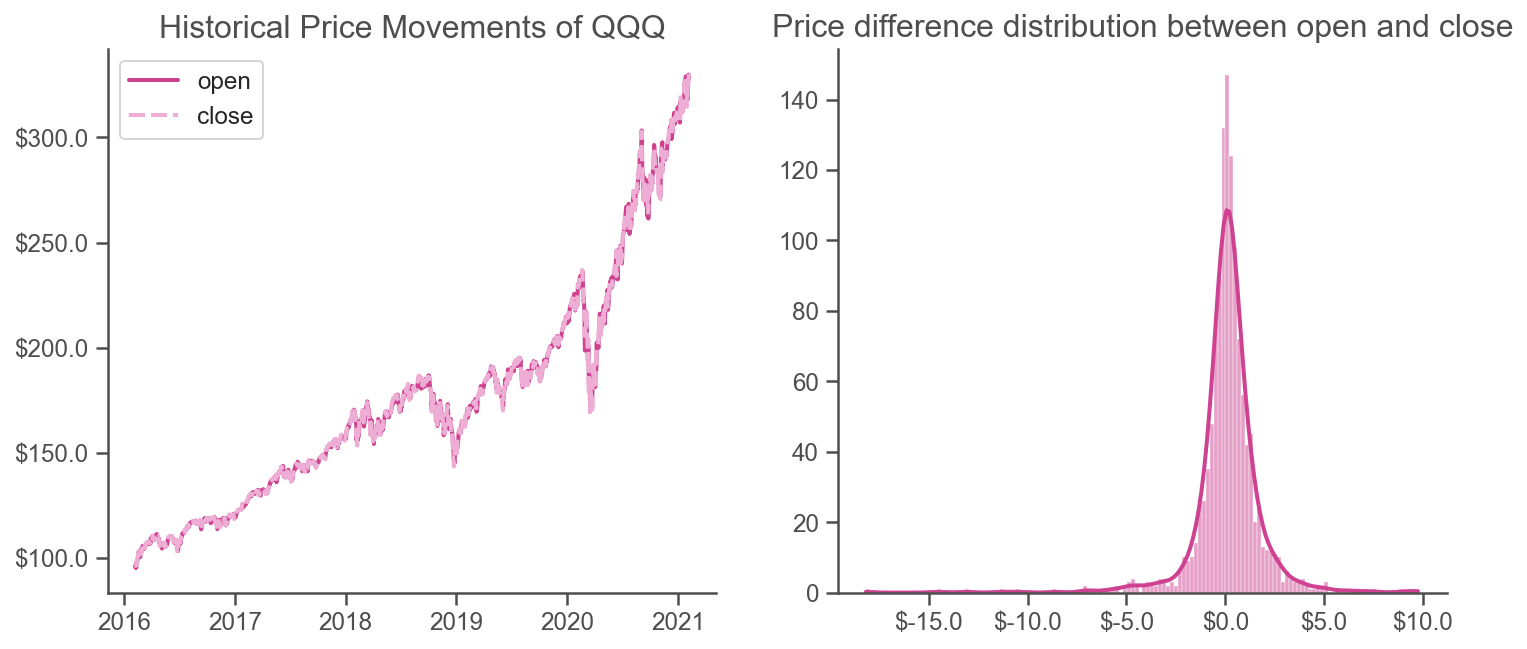

In [7]:
fig, (ax1, ax2) = plt.subplots(1, 2, figsize = (12, 5))

# plot historical open and close prices
sns.lineplot(data=historical_price[["open", "close"]], ax=ax1)
ax1.yaxis.set_major_formatter('${x:1.1f}')
ax1.set_title(f"Historical Price Movements of {SELECTED_TICKER}")
ax1.set(xlabel=None, ylabel=None)

# plot differences between open and close
sns.histplot(data=historical_price["diff"], binwidth=0.2, kde=True, ax=ax2)
ax2.xaxis.set_major_formatter('${x:1.1f}')
ax2.set_title(f"Price difference distribution between open and close")
ax2.set(xlabel=None, ylabel=None)

plt.show()

We use the T test below to test if on average the difference between close and the next open is greater than 0. A p value of less than 5% suggests that it's statistically significant on average the next day open is greater than previous close.

In [8]:
# hypothesis test on if the difference between historical open and close was > 0
scipy.stats.ttest_1samp(historical_price["diff"], 0, alternative='greater')

Ttest_1sampResult(statistic=2.6357422660500305, pvalue=0.004249340834019058)

<h2>3. Backtesting trading frequencies</h2>
<a id = "section3"></a>

In this section, we are going to run simulatins to construct 10,000 portfolios for the two trading frequencies mentioned above.

In [9]:
trading_w = TradingSimulation(historical_price, INTERVAL1, AMOUNT)
trading_m = TradingSimulation(historical_price, INTERVAL2, AMOUNT)

In [10]:
result_w = trading_w.compute_portfolio()
result_m = trading_m.compute_portfolio()

In [11]:
combined = pd.concat(
    [result_w[["portfolio_value", "return"]], 
     result_m[["portfolio_value", "return"]]], 
    axis=1
)

names=["value_w", "return_w", "value_m", "return_m"]
combined.columns = names

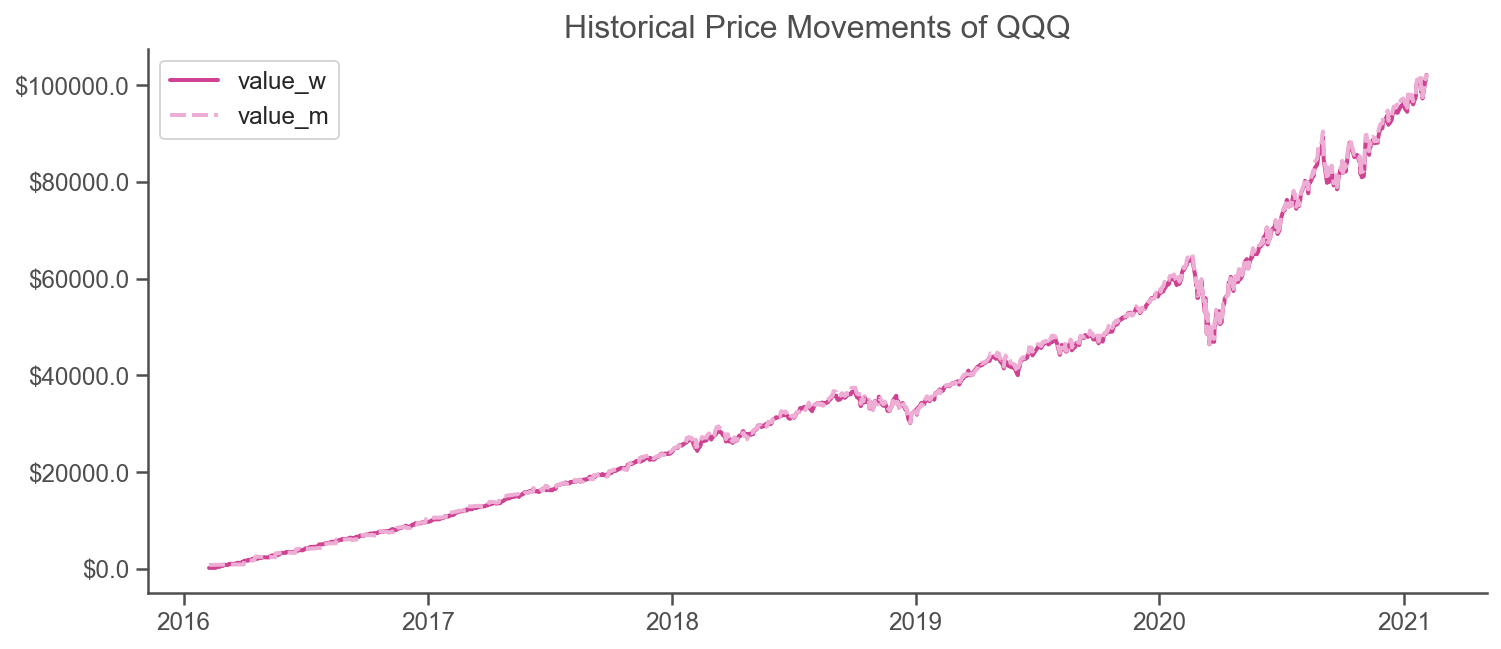

In [12]:
fig, ax = plt.subplots(figsize = (12, 5))

# plot historical open and close prices
sns.lineplot(data=combined[["value_w", "value_m"]])
ax.yaxis.set_major_formatter('${x:1.1f}')
ax.set_title(f"Historical Price Movements of {SELECTED_TICKER}")
ax.set(xlabel=None, ylabel=None)
plt.show()

In [13]:
# run the trading strategy for n times and compute tne terminal values
simulated_terminal_value_w = trading_w.run_simulation(current_price)[0]
simulated_terminal_value_m = trading_m.run_simulation(current_price)[0]

Again we use hypothesis testing to see if there's any statistically significant difference between the return from weekly vs monthly trading frequency out of the simulation. And the next to 0 p value suggests so.

In [14]:
# perform hypothesis test to see if trading monthly generates higher return than weekly over the examined period
scipy.stats.ttest_ind(
    simulated_terminal_value_w, 
    simulated_terminal_value_m, 
    equal_var=False, 
    alternative="two-sided")

Ttest_indResult(statistic=-280.05996431951854, pvalue=0.0)

Here, we take a shortcut only to compare variances from one simulation using Levne test. The result shows that the variances in return are not statistically different.

In [15]:
# perfrm Levene test for equal variances
# for simplicity, not running n simulations for this one
scipy.stats.levene(result_w["return"], result_m["return"])

LeveneResult(statistic=0.41950737295734974, pvalue=0.5172421000181149)

<h2>4. Comparing the risk and return for a selection of investments</h2>
<a id = "section4"></a>

In the final section, we'd like to compare a selection of assets for thier performances, and compute the 95% confidence interval for excess returns (if any).

In [16]:
TICKERS = ["QQQ", "TSLA", "GME", "BTC-USD", "WMT", "ARKK"]
results = YahooFinancials(TICKERS)

In [17]:
historical_raws = results.get_historical_price_data(START_DATE, END_DATE, "daily")
current_prices = results.get_current_price()

In [18]:
ci_lower = []
ci_upper = []
mean_diff = []
p_var = []

for i in TICKERS:
    # create price dataframe for all tickers and clean up
    historical_price = pd.DataFrame(historical_raws[i]["prices"]).drop(columns="date")
    historical_price["formatted_date"] = pd.to_datetime(historical_price["formatted_date"])
    historical_price.set_index("formatted_date", inplace=True)
    historical_price = historical_price.dropna()
    
    # run simulation
    trading_w = TradingSimulation(historical_price, INTERVAL1, AMOUNT)
    trading_m = TradingSimulation(historical_price, INTERVAL2, AMOUNT)
    
    simulated_w, return_w = trading_w.run_simulation(current_prices[i])
    simulated_m, return_m = trading_m.run_simulation(current_prices[i])
    
    diff_return = np.array(return_m) - np.array(return_w)
    diff_mean = np.mean(diff_return)
    
    ci = scipy.stats.t.interval(
        alpha=0.95, 
        df=len(diff_return)-1, 
        loc=diff_mean, 
        scale=scipy.stats.sem(diff_return)
    ) 
    # add confidence intervals and mean to corresponding lists
    ci_lower.append(ci[0])
    ci_upper.append(ci[1])
    mean_diff.append(diff_mean)
    
    # to check if the risks are significantly different
    result_w = trading_w.compute_portfolio()
    result_m = trading_m.compute_portfolio()
    
    stat, p = scipy.stats.levene(result_w["return"], result_m["return"])
    
    p_var.append(p)

In [19]:
comparisons = pd.DataFrame(
    {"tickers":TICKERS,
    "mean_diff":mean_diff,
    "ci_lower":ci_lower,
    "ci_upper":ci_upper,
    "p_var": p_var
    }
)
comparisons

,tickers,mean_diff,ci_lower,ci_upper,p_var
0,QQQ,0.02,0.01,0.02,0.69
1,TSLA,0.19,0.19,0.20,0.95
2,GME,0.04,0.04,0.04,0.96
3,BTC-USD,0.14,0.13,0.14,0.66
4,WMT,0.01,0.01,0.01,0.93
5,ARKK,0.06,0.05,0.06,0.74


We observe all monthly trades generate higher returns compared to weekly ones over the past 5 years under simulation. The returns are typically larger for volatile assets such as Bitcoin and TSLA. However, the excess return also comes with higher volatility as you can see from the wider confidence intervals in both asssets.

Typically, for those assets that experienced exponential growth later on, a larger size of investment in the earlier days provide earlier exposure to the value appreciation.

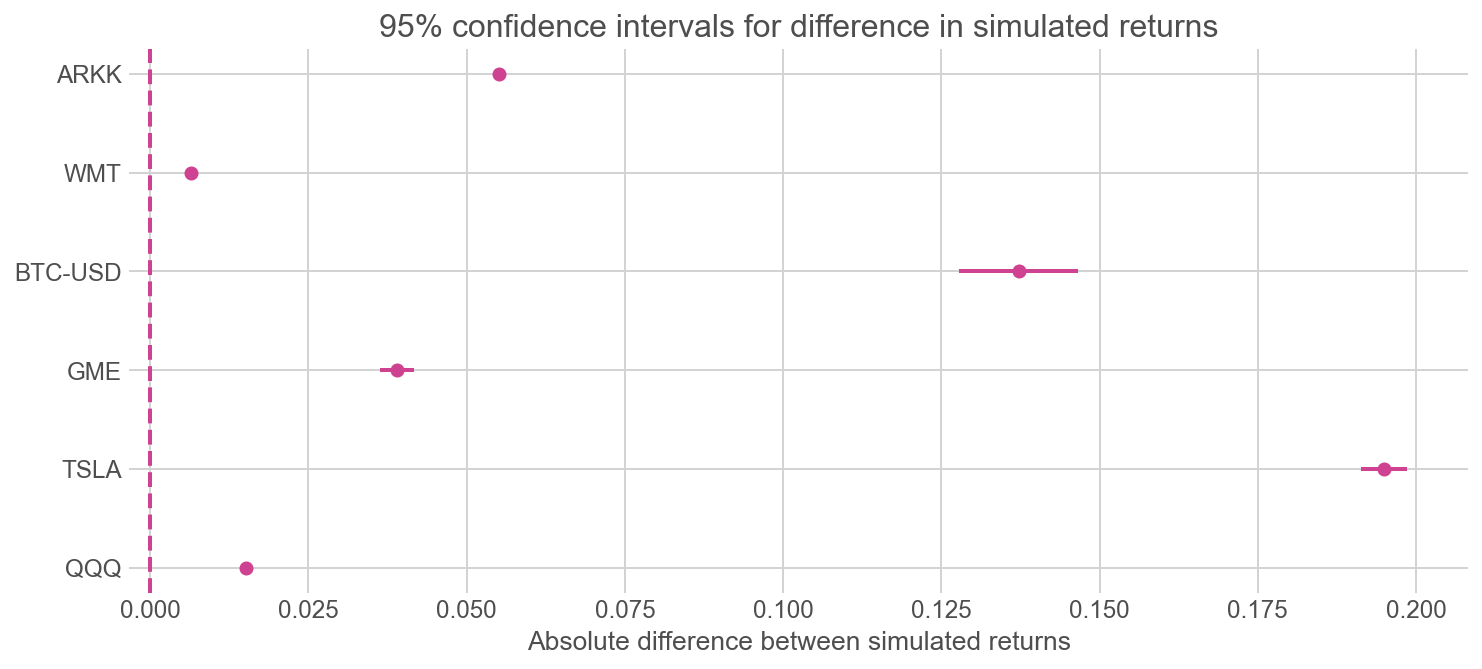

In [20]:
fig, ax = plt.subplots(figsize = (12, 5))

plt.grid(color='#d3d3d3', linestyle='solid')

plt.errorbar(
    x="mean_diff",
    y="tickers", 
    xerr=comparisons["ci_upper"] - comparisons["ci_lower"],
    fmt='o',
    data=comparisons)

ax.set_title(f"95% confidence intervals for difference in simulated returns")
ax.set(xlabel="Absolute difference between simulated returns", ylabel=None)

# hide axis spines
for spine in ax.spines.values():
    spine.set_visible(False)

# hide all ticks
ax.tick_params(length=0)

plt.axvline(x=0, linestyle="--")

plt.show()